In [1]:
import pandas as pd
from tqdm import tqdm
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde, binned_statistic_dd
from mpl_toolkits.mplot3d import Axes3D

In [2]:
file = "../data/SSCURVES.xlsx"

In [3]:
def logistic(x, a, k, xc):
    return a/(1 + np.exp(-k*(x-xc)))

In [4]:
def r2_fn(y, y_fit):
    # residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)

    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)

    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    
    return r2

In [5]:
def tsos(y):
    """Total sum of squares"""
    return np.sum((y-np.mean(y))**2)

def rsos(y, y_pred):
    """Residual sum of squares"""
    residuals = y - y_pred
    return np.sum(residuals**2)


def r_squared(y, y_pred):
    ss_tot = tsos(y)
    ss_res = rsos(y, y_pred)
    return 1 - ss_tot / ss_res


In [6]:
rs_results = []
def save_individual_fit(x, y, popt, sample_id, r2):
    y_pred = logistic(x, *popt)
    rs_results.append(r2)
    plt.figure(figsize=(3, 3), tight_layout=True)
    plt.plot(np.linspace(0, 2.5, 1000), logistic(np.linspace(0, 2.5, 1000), *popt), color='red', label="logistic fit")
    plt.scatter(x, y, marker='x', color='black', label="data")
    plt.xlabel("Stretch")
    plt.ylabel("Stress [MPa]")
    plt.title(f"Sample {sample_id}")
    plt.xlim([1, 1.6])
    plt.annotate(f"$R^2 = {r2:.4f}$", [0.05, 0.9], xycoords='axes fraction')
    if sample_id == "6":
        plt.legend(loc='lower right')
    plt.savefig(f"outputs/logistic-fits/sample_{sample_id}.pdf")

  3%|██                                                              | 2/63 [00:00<00:05, 10.92it/s]

Only curves belonging to thigh are included. Excluding person 1 (sheet 1)
Only curves belonging to thigh are included. Excluding person 1 (sheet 2)
Only curves belonging to thigh are included. Excluding person 2 (sheet 3)


  6%|████                                                            | 4/63 [00:00<00:05, 10.53it/s]

Only curves belonging to thigh are included. Excluding person 2 (sheet 4)
Only curves belonging to thigh are included. Excluding person 3 (sheet 5)


 38%|████████████████████████                                       | 24/63 [00:08<00:14,  2.64it/s]/tmp/ipykernel_2830968/3455127893.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(3, 3), tight_layout=True)
100%|███████████████████████████████████████████████████████████████| 63/63 [00:23<00:00,  2.67it/s]


No person id information found for 62
No person id information found for 555
    index          a          k        xc        r2  person_id      sex  \
0       6  11.907112  23.358183  1.343536  0.998290          4  unknown   
1       7   7.626809  25.646122  1.473007  0.999788          5     male   
2       8   4.642277  23.513952  1.472741  0.999895          6     male   
3       9   7.959597  19.331536  1.331278  0.998797          6     male   
4      10   3.309715  28.963632  1.201851  0.996660          7     male   
5      11   5.994179  23.651890  1.179996  0.994457          8     male   
6      12   3.663657  21.963652  1.265844  0.999329          9     male   
7      13   2.427453  17.765873  1.289461  0.998854         10   female   
8      14   3.146789  46.671645  1.402187  0.998000         11  unknown   
9      15  14.306805  26.773711  1.185899  0.999180         12  unknown   
10     16   4.064649  29.401408  1.321485  0.996641         13     male   
11     17   3.485572  2

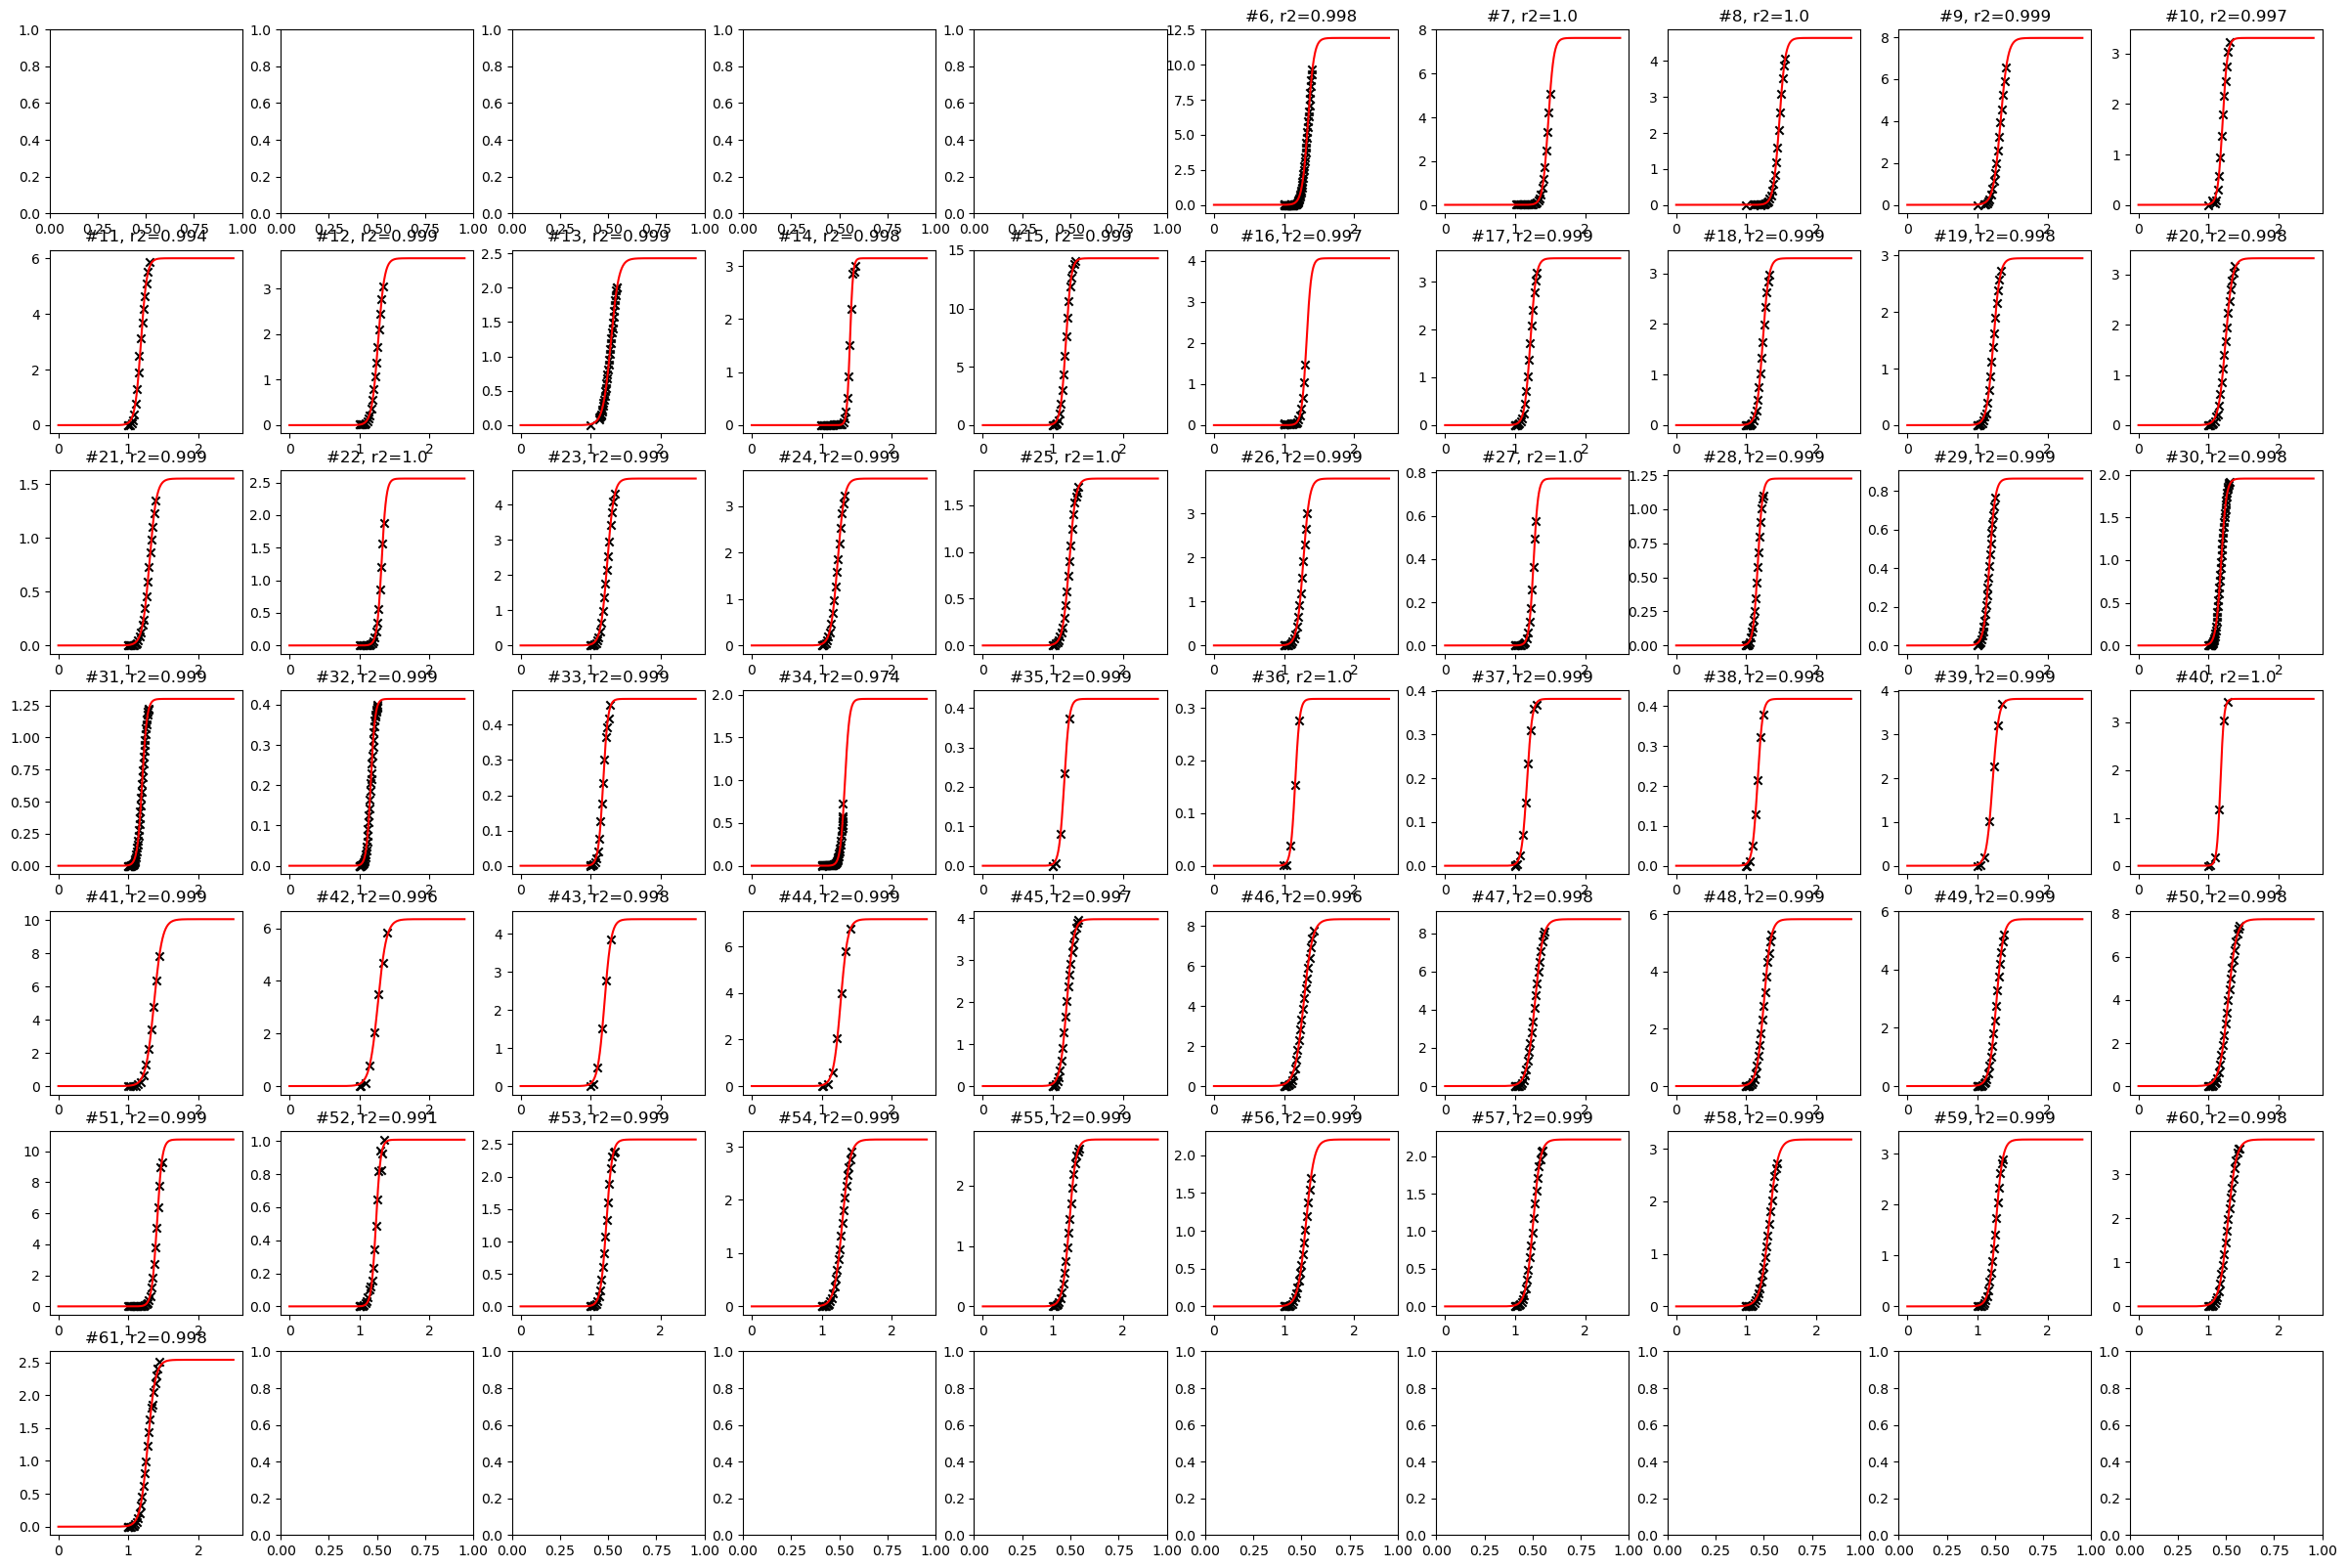

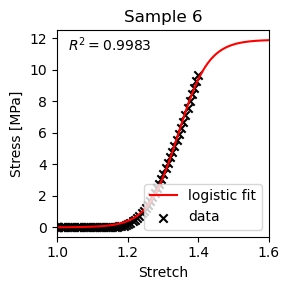

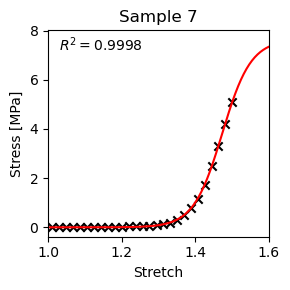

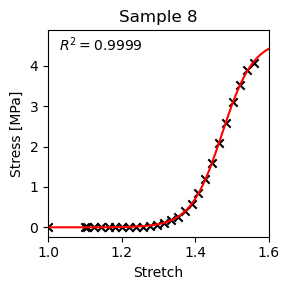

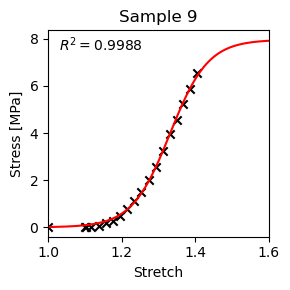

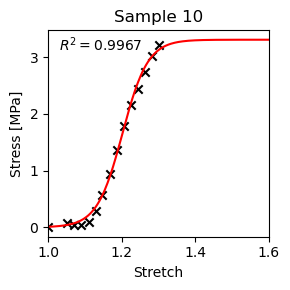

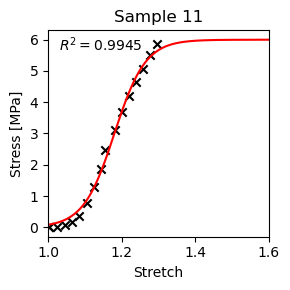

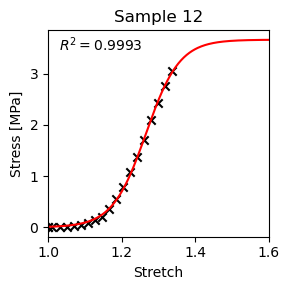

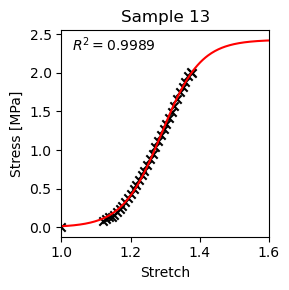

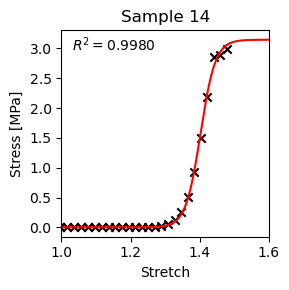

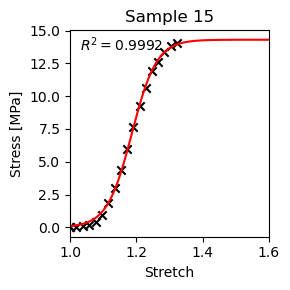

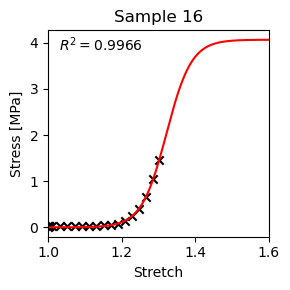

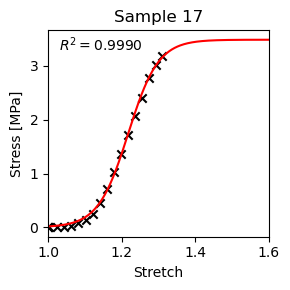

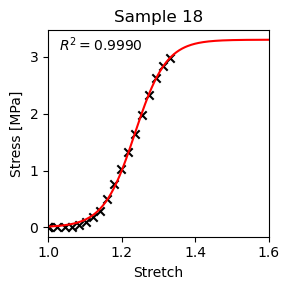

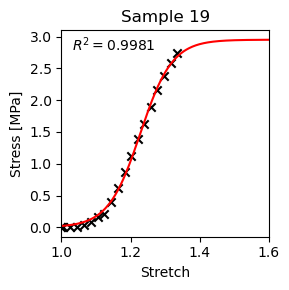

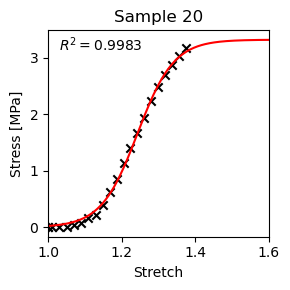

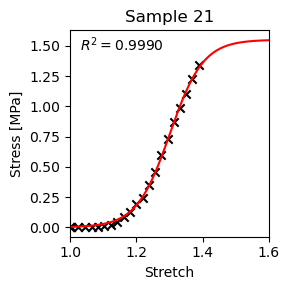

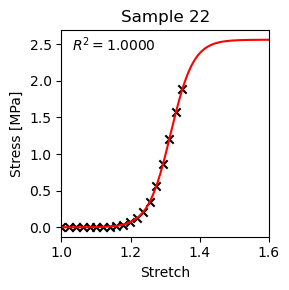

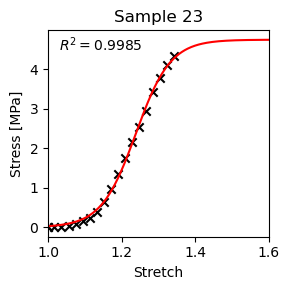

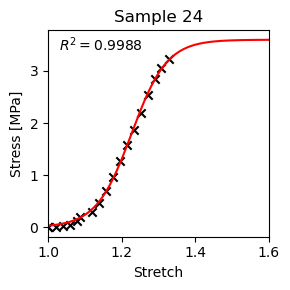

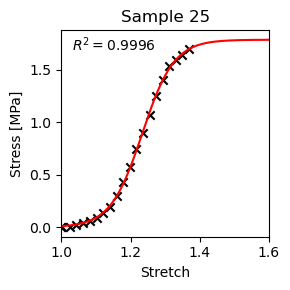

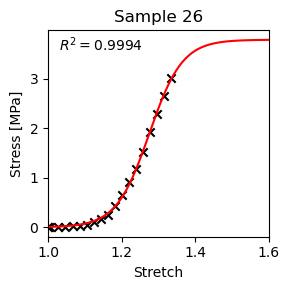

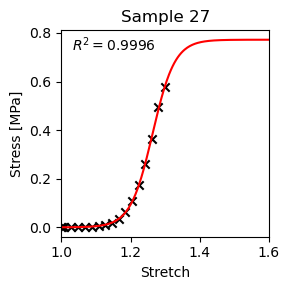

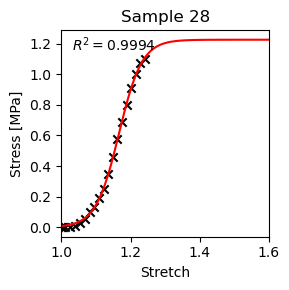

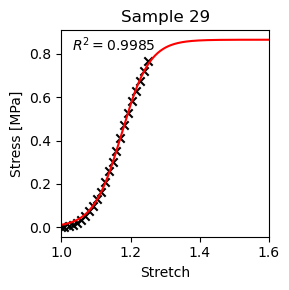

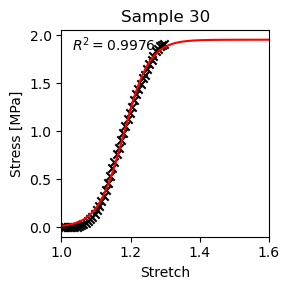

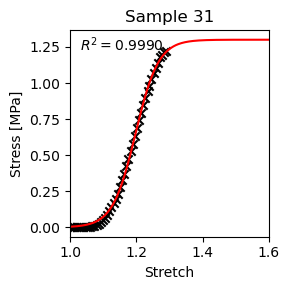

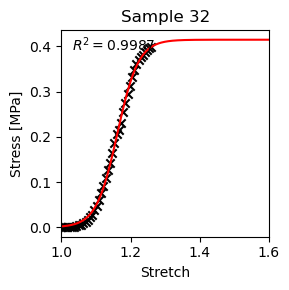

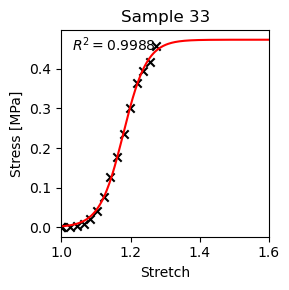

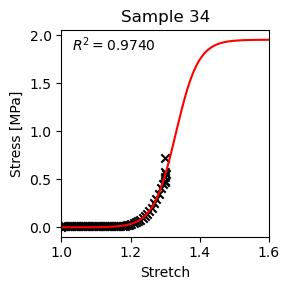

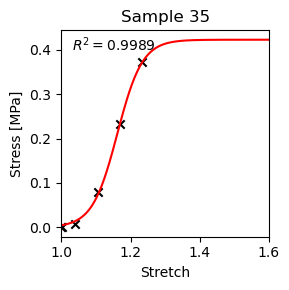

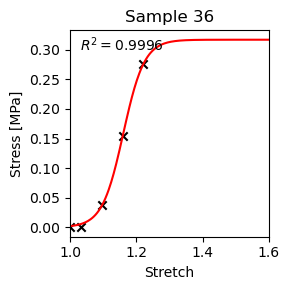

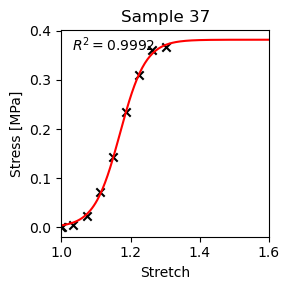

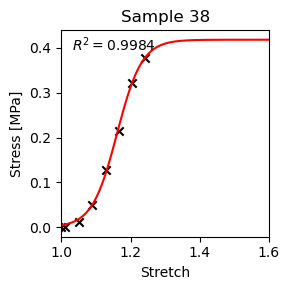

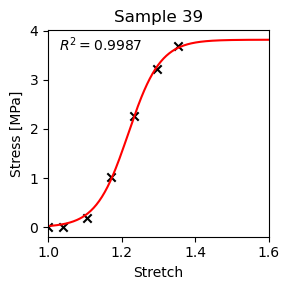

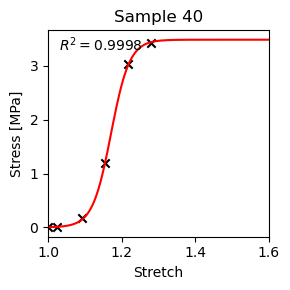

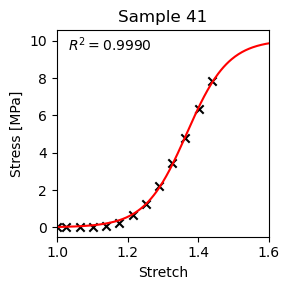

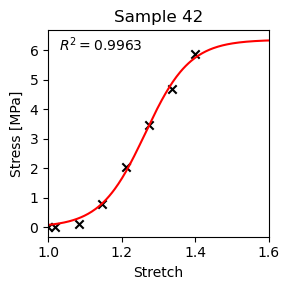

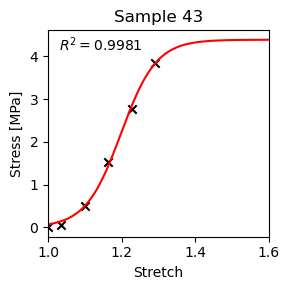

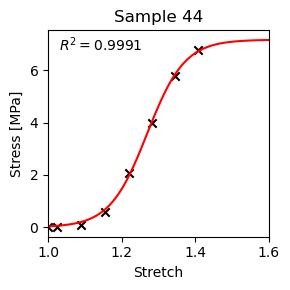

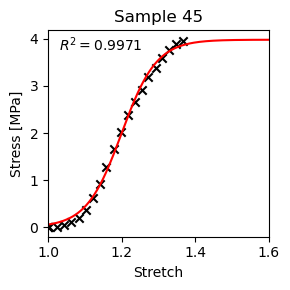

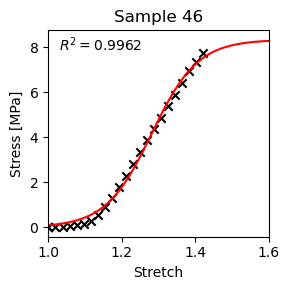

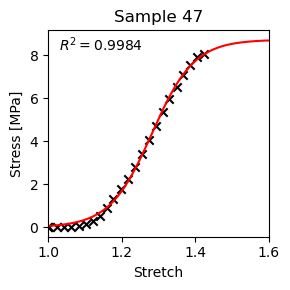

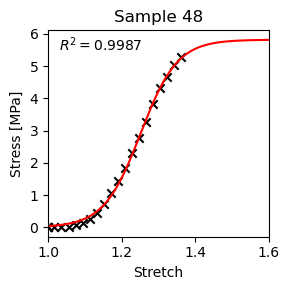

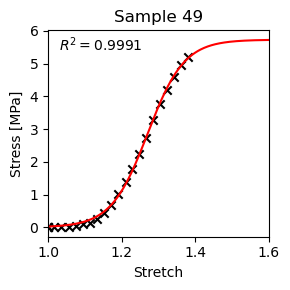

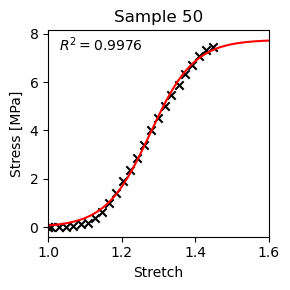

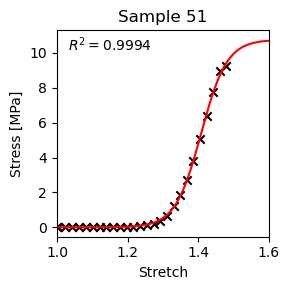

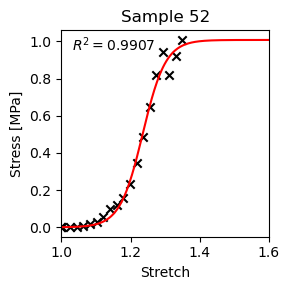

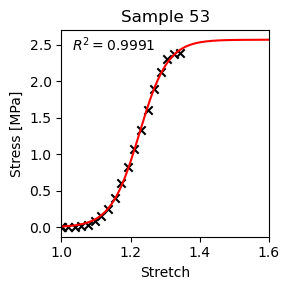

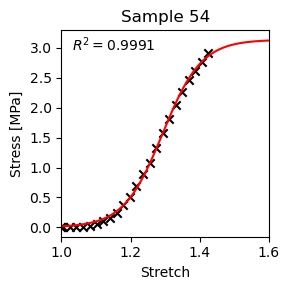

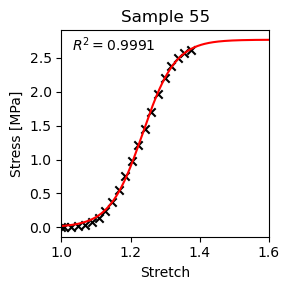

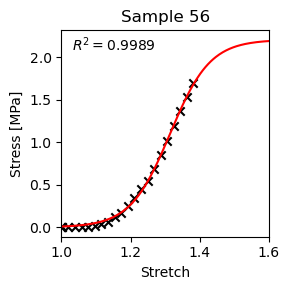

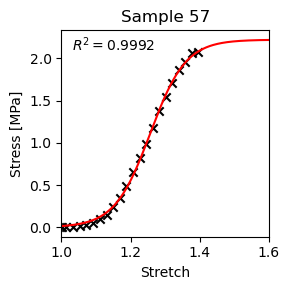

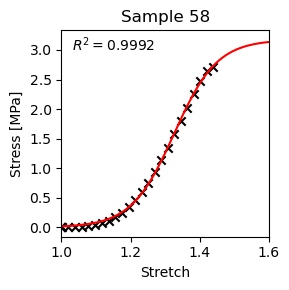

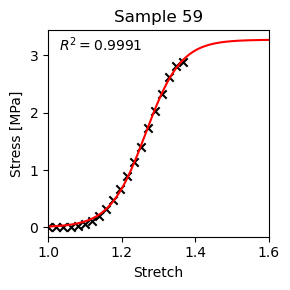

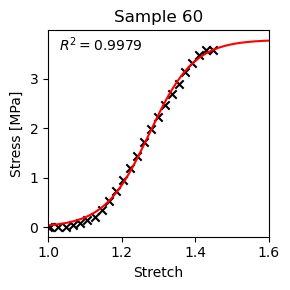

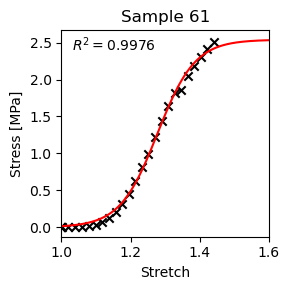

In [7]:
xls = pd.ExcelFile(file)

index_list =  []
person_ids = []
ages = []
sexes = []
a_list = []
k_list = []
xc_list = []

r2_list = []

fig, axs = plt.subplots(7, 10, figsize=(30,20))
x = np.linspace(0, 2.5, 1000)


for sheet, ax in tqdm(zip(xls.sheet_names, axs.flat), total=len(xls.sheet_names), ncols=100):
    df = pd.read_excel(file, sheet_name=sheet)

    try:
        person_id = int(df['id'].iloc[0])
        type = str(df['type'].iloc[0])
        sex = str(df['sex'].iloc[0])
        age = str(df['age'].iloc[0])
    except KeyError:
        print(f"No person id information found for {sheet}")
        person_id = None
        continue

    valid_type = 'thigh'
    if type != valid_type:
        tqdm.write(f"Only curves belonging to {valid_type} are included. Excluding person {person_id} (sheet {sheet})")
        continue

    df = df.groupby(["Strain"], as_index=False).agg({'Stress': 'mean'})
    df = df.sort_values("Strain")

    # if len(df) < 15:
    #     continue

    person_ids.append(person_id)
    sexes.append(sex)
    ages.append(age)

    x_data = df['Strain']
    y_data = df['Stress']

    popt, _ = curve_fit(logistic, x_data, y_data, bounds=((0, -np.inf, -np.inf), (np.inf, np.inf, np.inf)), maxfev=10000)#bounds=((0, -np.inf,-np.inf,0),(np.inf, np.inf, np.inf,np.inf)), maxfev=10000)
    index_list.append(int(sheet))
    a_list.append(popt[0])
    k_list.append(popt[1])
    xc_list.append(popt[2])


    r2 = r2_fn(y_data, logistic(x_data, *popt))
    r2_list.append(r2)

    save_individual_fit(x_data, y_data, popt, sheet, r2)

    ax.scatter(x_data, y_data, marker='x', color='black')
    ax.plot(x, logistic(x, *popt), 'r-')
    ax.set_title(f"#{sheet}, r2={round(r2, 3)}")


data = {
    "index": index_list,

    "a": a_list,
    "k": k_list,
    "xc": xc_list,
    "r2": r2_list,
    "person_id": person_ids,
    "sex": sexes,
    "age": ages,
}


df = pd.DataFrame.from_dict(data)
print(df)

plt.tight_layout()
plt.savefig("outputs/logistic_fits.png")
plt.show()


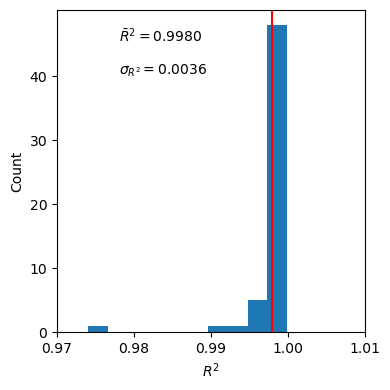

In [8]:
plt.figure(figsize=(4, 4), tight_layout=True)
plt.hist(rs_results)
plt.axvline(np.mean(rs_results), c='red')
plt.annotate(r"$\bar{R}^2" + f" = {np.mean(rs_results):.4f}$", [0.2, 0.9], xycoords='axes fraction')
plt.annotate(r"$\sigma_{R^2}" + f" = {np.std(rs_results):.4f}$", [0.2, 0.8], xycoords='axes fraction')
# plt.xticks([0.9875, 0.9925, 0.9975, 1.0025])
plt.xticks(np.arange(0.97, 1.01, 0.01))
plt.yticks(np.arange(0, 50, 10))
plt.xlabel("$R^2$")
plt.ylabel("Count")
plt.savefig("outputs/logistic-fits/r2_hist.pdf")

In [9]:
print(df.groupby(["person_id", "sex", "age"]).size())

person_id  sex      age    
4          unknown  unknown     1
5          male     61.0        1
6          male     66.0        2
7          male     79.0        1
8          male     77.0        1
9          male     75.0        1
10         female   94.0        1
11         unknown  unknown     1
12         unknown  unknown     1
13         male     82.0        3
14         female   90.0        4
15         female   87.0        5
16         male     95.0       12
17         male     83.0       13
18         female   88.0        9
dtype: int64


In [10]:
print(df.groupby(["person_id", "sex", "age"]).size().to_latex())

\begin{tabular}{lllr}
\toprule
   &        &      &   0 \\
person\_id & sex & age &     \\
\midrule
4  & unknown & unknown &   1 \\
5  & male & 61.0 &   1 \\
6  & male & 66.0 &   2 \\
7  & male & 79.0 &   1 \\
8  & male & 77.0 &   1 \\
9  & male & 75.0 &   1 \\
10 & female & 94.0 &   1 \\
11 & unknown & unknown &   1 \\
12 & unknown & unknown &   1 \\
13 & male & 82.0 &   3 \\
14 & female & 90.0 &   4 \\
15 & female & 87.0 &   5 \\
16 & male & 95.0 &  12 \\
17 & male & 83.0 &  13 \\
18 & female & 88.0 &   9 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2830968/2939388368.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.groupby(["person_id", "sex", "age"]).size().to_latex())


In [11]:
df.groupby(["person_id", "sex", "age"]).size()

person_id  sex      age    
4          unknown  unknown     1
5          male     61.0        1
6          male     66.0        2
7          male     79.0        1
8          male     77.0        1
9          male     75.0        1
10         female   94.0        1
11         unknown  unknown     1
12         unknown  unknown     1
13         male     82.0        3
14         female   90.0        4
15         female   87.0        5
16         male     95.0       12
17         male     83.0       13
18         female   88.0        9
dtype: int64

In [12]:
print(df.person_id.unique())
len(df.person_id.unique())

[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


15

In [13]:
df.to_csv("outputs/logistic_targets.csv", index=False) # We have our own indices.

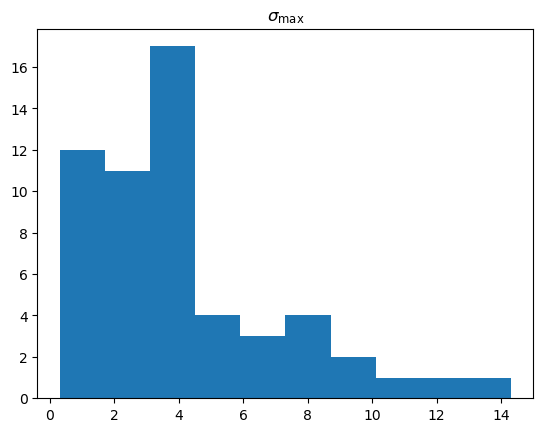

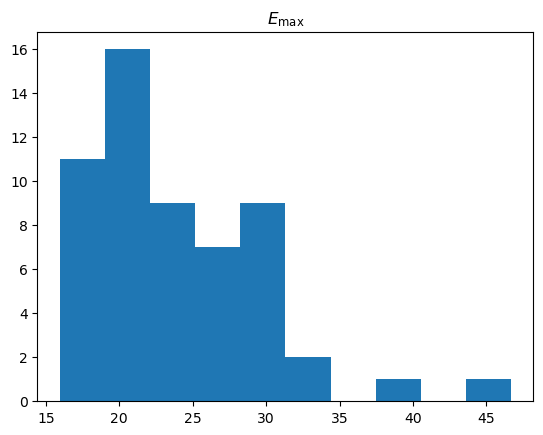

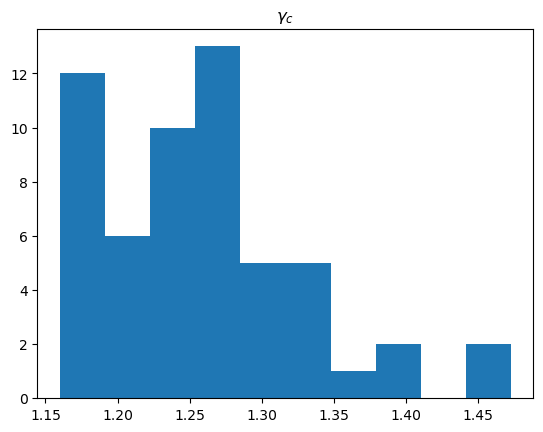

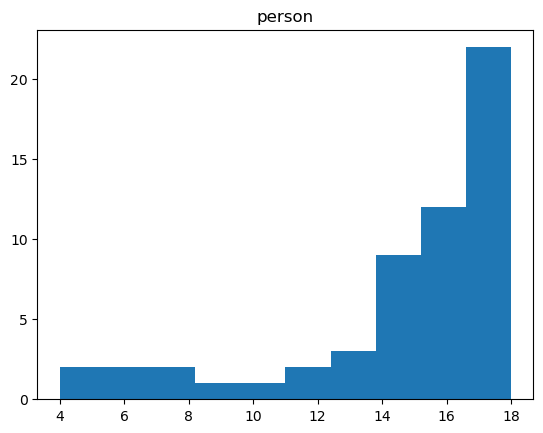

In [14]:
for param, name in zip(["a", "k", "xc", "person_id"], [r"$\sigma_\mathrm{max}$", r"$E_\mathrm{max}$", r"$\gamma_c$", "person"]):
    fig, ax = plt.subplots()
    ax.hist(df[[param]])
    ax.set_title(name)

array([[<AxesSubplot: title={'center': 'person_id'}>]], dtype=object)

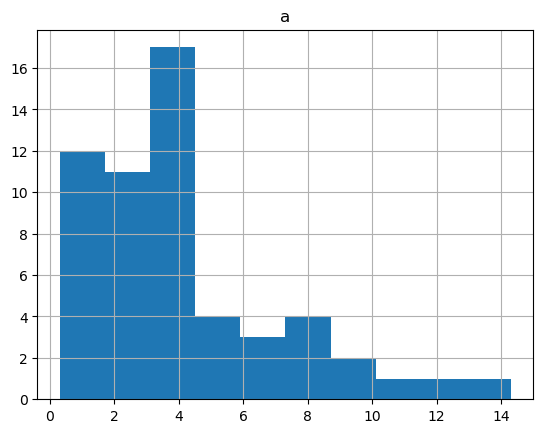

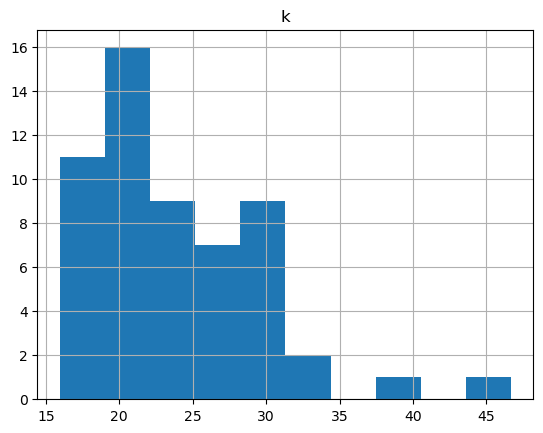

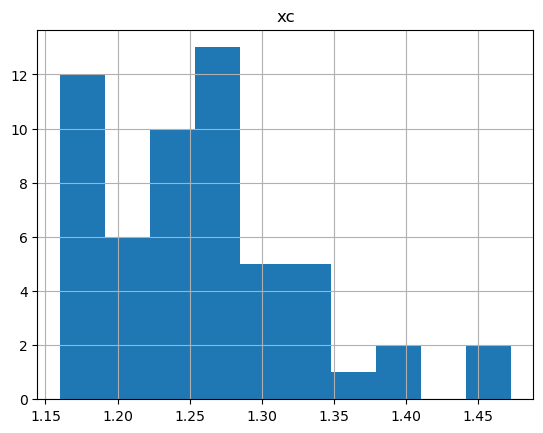

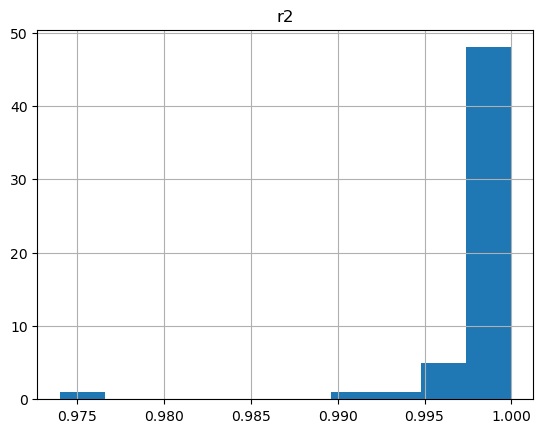

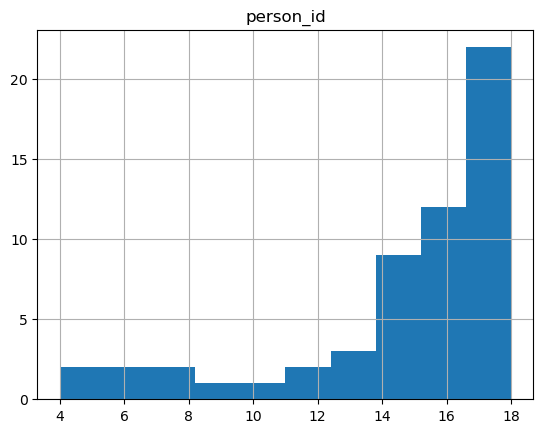

In [15]:
df.hist(column='a')
df.hist(column='k')
df.hist(column='xc')
df.hist(column='r2')
df.hist(column='person_id')

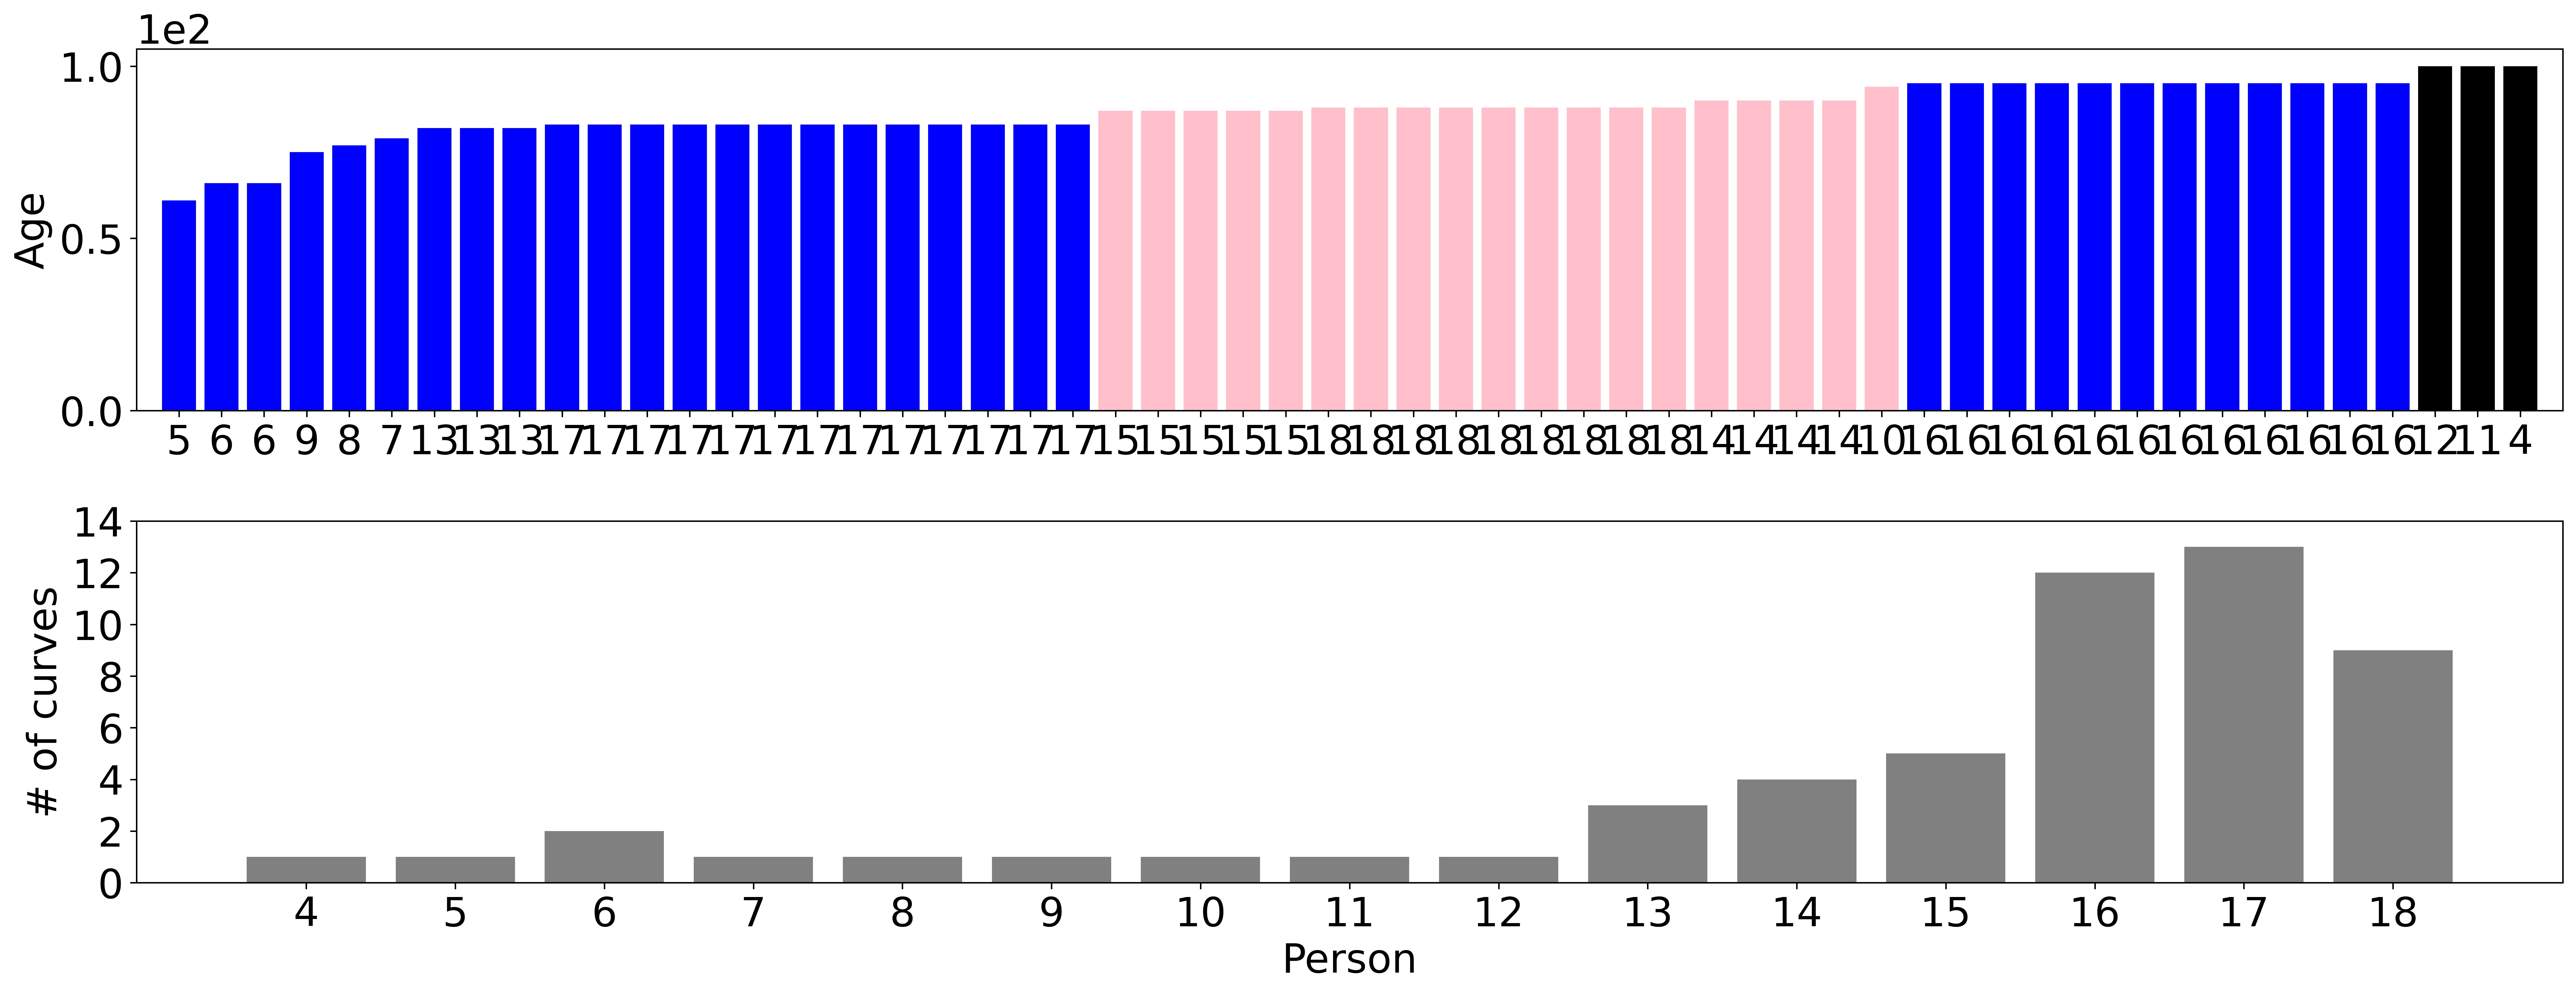

In [16]:
import matplotlib
matplotlib.pyplot.style.use("ipynb")
# SMALL_SIZE = 10
# MEDIUM_SIZE = 15
# BIGGER_SIZE = 20

# matplotlib.rcParams.update({'font.size': 22})

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

matplotlib.rcParams.update({'font.size': 22})

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(20, 8))
sorted_df = df.sort_values("age")
colors = []
for sex in sorted_df["sex"]:
    if sex == "male":
        colors.append("blue")
    elif sex == "female":
        colors.append("pink")
    else:
        colors.append("black")
ages = []
for age in sorted_df["age"]:
    try:
        ages.append(float(age))
    except ValueError:
        ages.append(100)

ax.bar(np.arange(0, len(ages), 1), ages, color=colors)
ax.set_xticks(np.arange(0, len(ages), 1))
ax.set_xticklabels(sorted_df["person_id"].to_numpy())
ax.set_ylabel("Age")
# ax.set_xlabel("Person")
ax.set_xlim(-1, len(ages))

numbers = df.groupby(["person_id", "age", "sex"]).size().to_numpy()
number = [float(n) for n in numbers]
people = np.sort(sorted_df["person_id"].unique())

ax2.bar(people, number, color="gray")
ax2.set_xticks(np.arange(4, len(people) + 4, 1))
ax2.set_xticklabels(people)
ax2.set_ylim(top=14)
ax2.set_yticks(np.arange(0, 16, 2))
ax2.set_yticklabels(np.arange(0, 16, 2))
ax2.set_ylabel("# of curves")
ax2.set_xlabel("Person")
plt.tight_layout()
plt.savefig("outputs/age_distribution.pdf")
plt.show()

In [109]:
sorted_df

,index,a,k,xc,r2,person_id,sex,age,colors
1,7,7.626809,25.646122,1.473007,0.999788,5,male,61.0,lightblue
2,8,4.642277,23.513952,1.472741,0.999895,6,male,66.0,lightblue
3,9,7.959597,19.331536,1.331278,0.998797,6,male,66.0,lightblue
6,12,3.663657,21.963652,1.265844,0.999329,9,male,75.0,lightblue
5,11,5.994179,23.651890,1.179996,0.994457,8,male,77.0,lightblue
4,10,3.309715,28.963632,1.201851,0.996660,7,male,79.0,lightblue
11,17,3.485572,24.474050,1.217597,0.998983,13,male,82.0,lightblue
10,16,4.064649,29.401408,1.321485,0.996641,13,male,82.0,lightblue
12,18,3.301961,23.380835,1.235641,0.998955,13,male,82.0,lightblue
39,45,3.981700,21.016575,1.199309,0.997102,17,male,83.0,lightblue


In [90]:
# sorted_df[sorted_df["sex"] == "male"]["colors"] = "blue"
sorted_df["colors"] = ""
sorted_df.loc[sorted_df["sex"] == "male", "colors"] = "lightblue"
sorted_df.loc[sorted_df["sex"] == "female", "colors"] = "pink"
sorted_df.loc[sorted_df["sex"] == "unknown", "colors"] = "lightgray"
sorted_df.loc[sorted_df["age"] == "unknown", "age"] = 100

In [104]:
sorted_df = sorted_df.astype({"age": np.float_})

/tmp/ipykernel_2830968/723314360.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


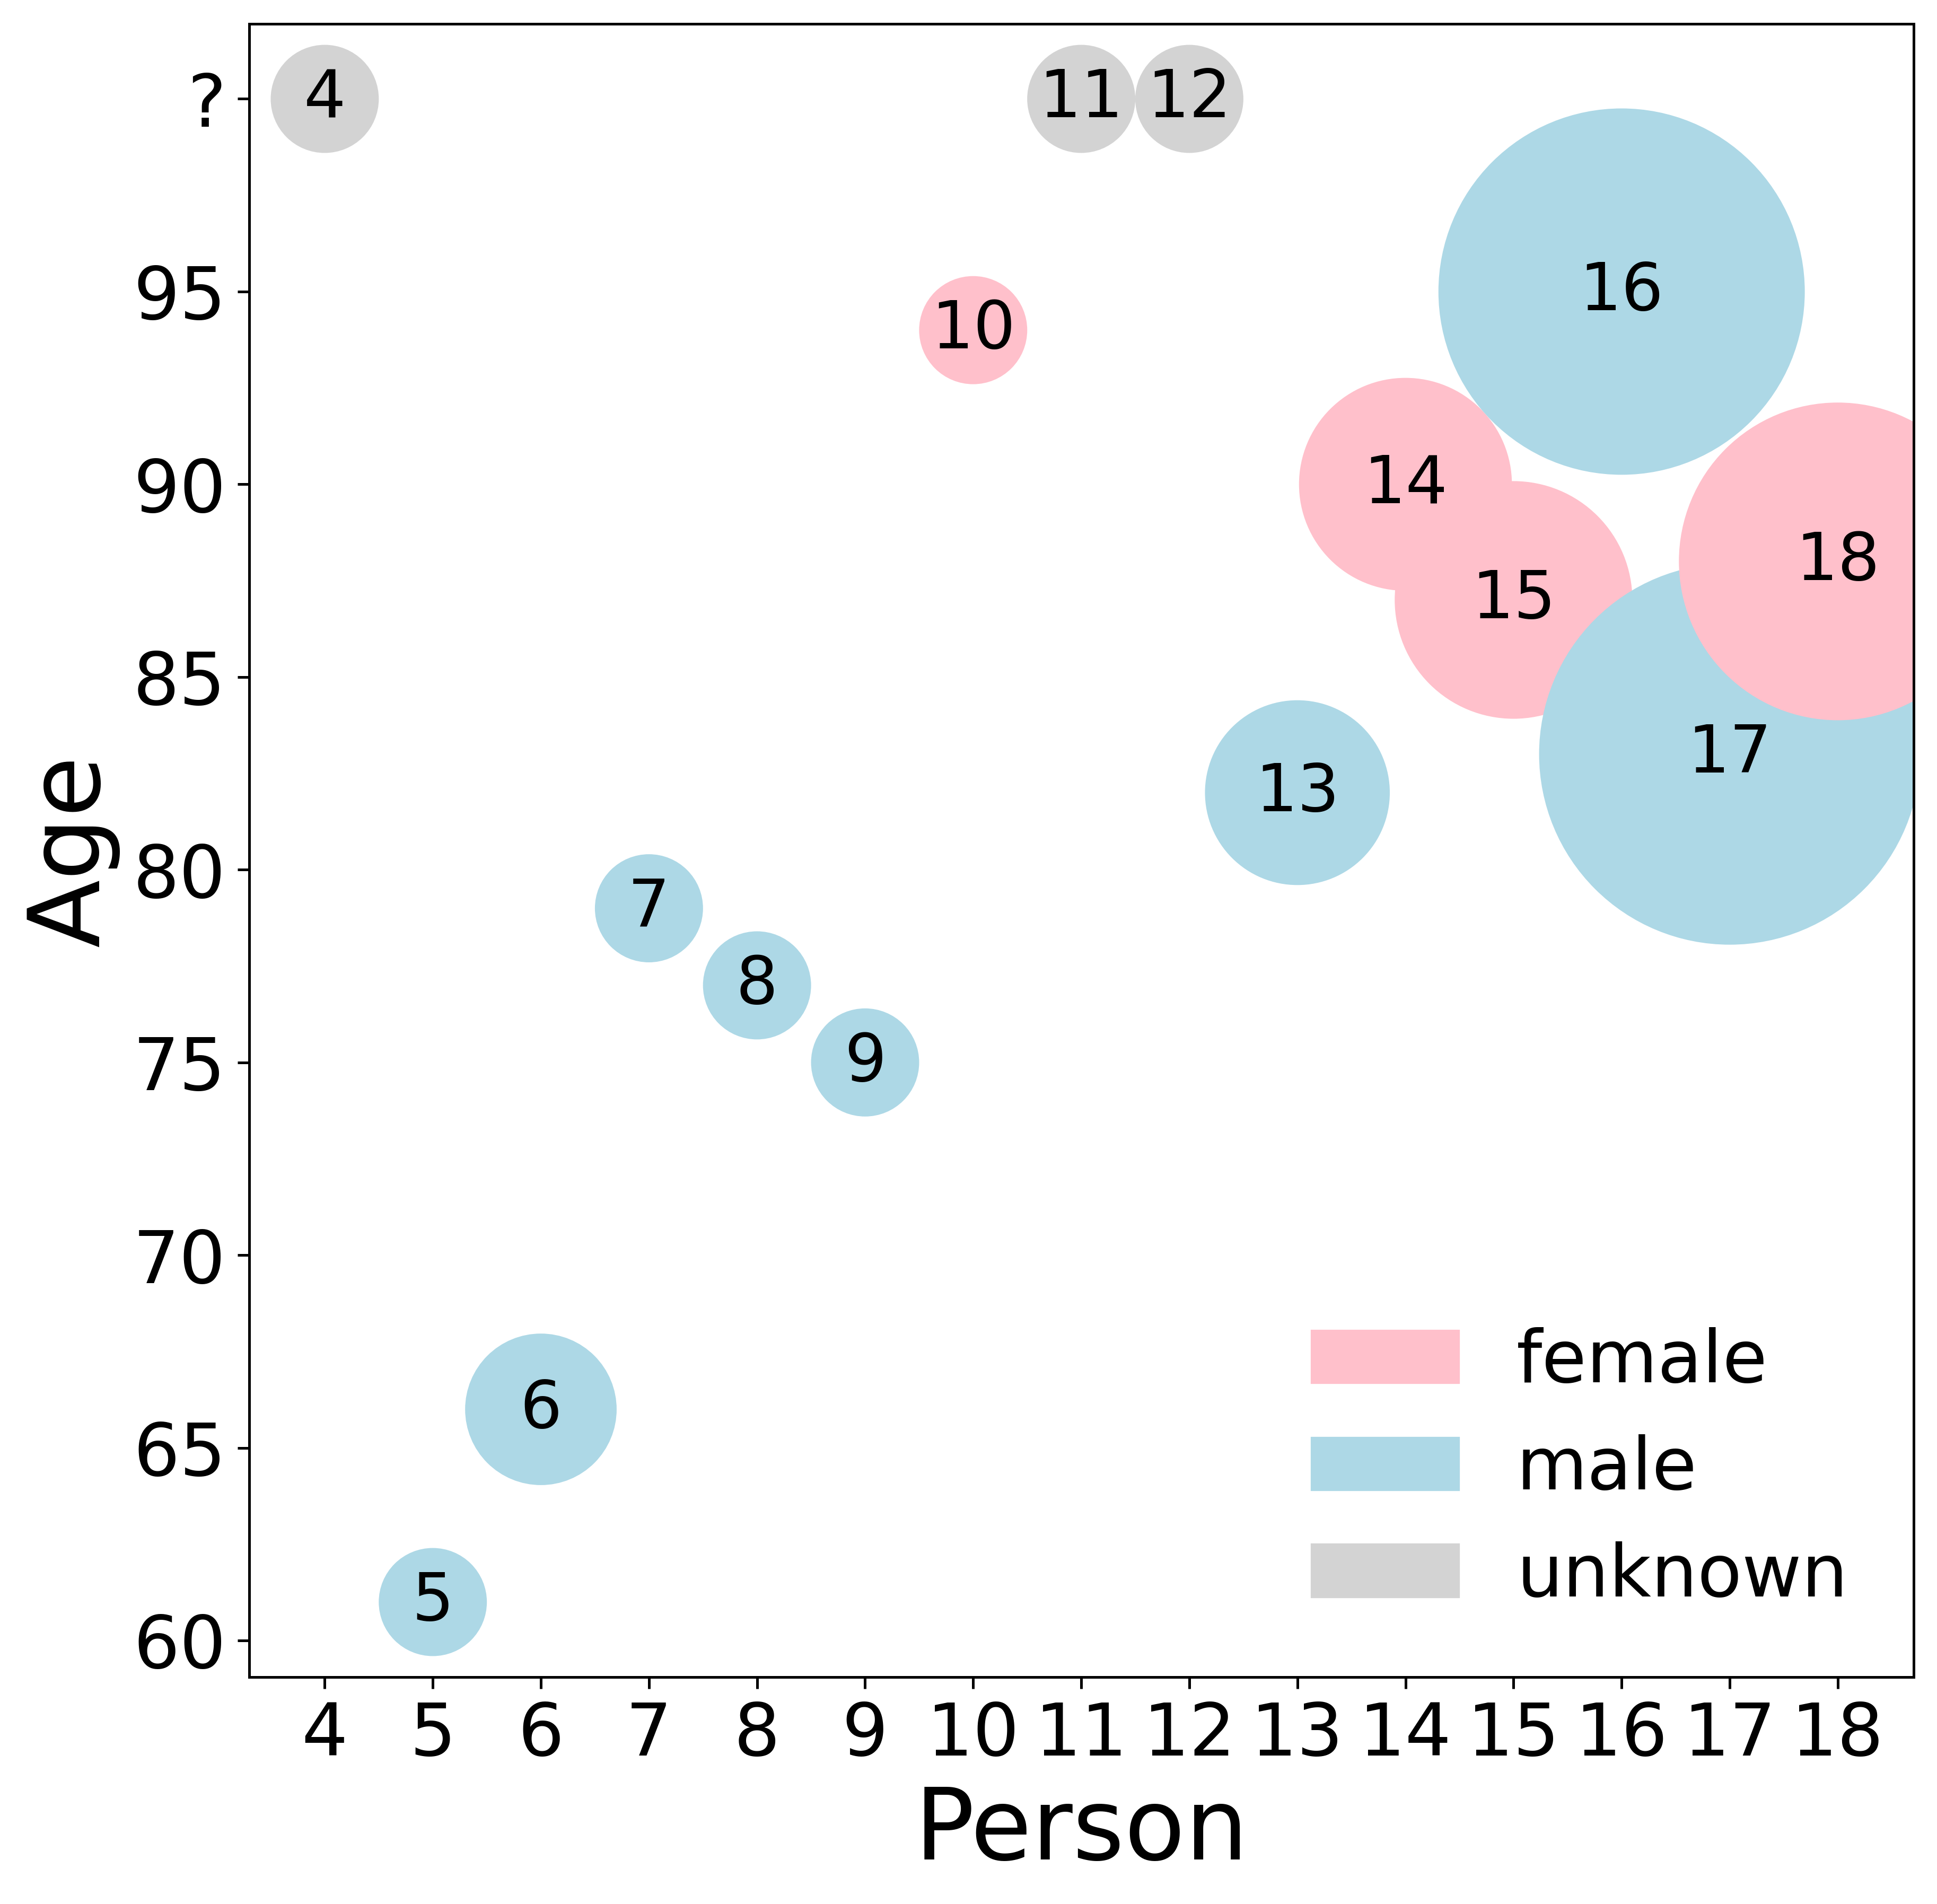

In [136]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(9, 9))
ax.scatter(np.sort(sorted_df["person_id"].unique()), sorted_df.groupby("person_id").aggregate("max")["age"], s=1000 * sorted_df.groupby("person_id").aggregate("count")["index"], c=sorted_df.groupby("person_id").aggregate("max")["colors"])
for i, num in enumerate(np.sort(sorted_df["person_id"].unique())):
    ax.text(np.sort(sorted_df["person_id"].unique())[i], sorted_df.groupby("person_id").aggregate("max")["age"].iloc[i], num, va="center", ha="center", fontsize=20)
ax.set_xlabel("Person", fontsize=30)
ax.set_xticks(np.arange(4, len(people)+4, 1))
ax.set_xticklabels(people)
ax.set_ylabel("Age", fontsize=30)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[-2] = '?'
ax.set_yticklabels(labels)
pink_patch = mpatches.Patch(color='pink', label='female')
blue_patch = mpatches.Patch(color='lightblue', label='male')
lightgray_patch = mpatches.Patch(color='lightgray', label='unknown')
ax.legend(handles=[pink_patch, blue_patch, lightgray_patch], loc="lower right")
fig.savefig("outputs/age_distribution.pdf", bbox_inches="tight", dpi=300)